# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm

# magic word for producing visualizations in notebook
%matplotlib inline

In [11]:
# import os
# import shutil

# copy data files to home directory
# shutil.copy("../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv", "./Udacity_AZDIAS_052018.csv")
# shutil.copy("../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv", "./Udacity_CUSTOMERS_052018.csv")

# Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [7]:
# load in the azdias dataset first

azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


### Part 0.1 - Update column 18 & 19 from azdias 
1) explore mixed types of data within the column and make correction
2) standardize the data type afterwards

In [4]:
azdias.columns[18]

'CAMEO_DEUG_2015'

In [5]:
azdias.columns[19]

'CAMEO_INTL_2015'

In [6]:
# display unique value in the column 18 

azdias['CAMEO_DEUG_2015'].unique() 

array([nan, 8.0, 4.0, 2.0, 6.0, 1.0, 9.0, 5.0, 7.0, 3.0, '4', '3', '7',
       '2', '8', '9', '6', '5', '1', 'X'], dtype=object)

In [7]:
# replace string X as NaN and convert column type to float

azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'].replace('X', np.NaN)

azdias['CAMEO_DEUG_2015'] = azdias['CAMEO_DEUG_2015'] .astype(float)

azdias['CAMEO_DEUG_2015'].unique() 

array([ nan,   8.,   4.,   2.,   6.,   1.,   9.,   5.,   7.,   3.])

In [8]:
# display unique value from column 19

azdias['CAMEO_INTL_2015'].unique()

array([nan, 51.0, 24.0, 12.0, 43.0, 54.0, 22.0, 14.0, 13.0, 15.0, 33.0,
       41.0, 34.0, 55.0, 25.0, 23.0, 31.0, 52.0, 35.0, 45.0, 44.0, 32.0,
       '22', '24', '41', '12', '54', '51', '44', '35', '23', '25', '14',
       '34', '52', '55', '31', '32', '15', '13', '43', '33', '45', 'XX'], dtype=object)

In [9]:
# replace string XX with NaN and convert column type to float

azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace('XX', np.NaN)

azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(float)

azdias['CAMEO_INTL_2015'].unique() 

array([ nan,  51.,  24.,  12.,  43.,  54.,  22.,  14.,  13.,  15.,  33.,
        41.,  34.,  55.,  25.,  23.,  31.,  52.,  35.,  45.,  44.,  32.])

In [10]:
# display data types 

azdias.get_dtype_counts()

float64    269
int64       93
object       4
dtype: int64

In [11]:
# standardize numerical columns to float 

for col in azdias.columns: 
    if azdias[col].dtype == np.int64:
        azdias[col] = azdias[col].astype(np.float64)
        
azdias.get_dtype_counts()

float64    362
object       4
dtype: int64

In [12]:
# view categorical columns 

azdias.select_dtypes(exclude=np.number).head(20)

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,D19_ENERGIE,1992-02-12 00:00:00,W
6,4A,D19_UNBEKANNT,1992-02-12 00:00:00,W
7,2D,D19_UNBEKANNT,1992-02-10 00:00:00,W
8,1A,NaN,1992-02-10 00:00:00,W
9,1E,D19_KOSMETIK,1992-02-10 00:00:00,W


### Part 0.2 upload azdiaz attribute files and verify data contents

In [13]:
# load DIAS Information Levels - Attributes 2017 data

levels = pd.read_excel('DIAS Information Levels - Attributes 2017.xlsx')

levels.head(10)

,Unnamed: 0,Information level,Attribute,Description,Additional notes
0,NaN,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,NaN,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,NaN,ANREDE_KZ,gender,NaN
3,NaN,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...
5,NaN,NaN,FINANZ_SPARER,financial typology: money saver,NaN
6,NaN,NaN,FINANZ_VORSORGER,financial typology: be prepared,NaN
7,NaN,NaN,FINANZ_ANLEGER,financial typology: investor,NaN
8,NaN,NaN,FINANZ_UNAUFFAELLIGER,financial typology: unremarkable,NaN
9,NaN,NaN,FINANZ_HAUSBAUER,financial typology: main focus is the own house,NaN


In [14]:
del levels['Unnamed: 0']

levels.isnull().sum()

Information level    303
Attribute              0
Description            0
Additional notes     293
dtype: int64

In [15]:
levels.shape

(313, 4)

There are 4 data columns DIAS Information Levels - Attributes 2017.xlsx file; however, both 'information level' and 'Additional notes' columns contain more than 90% NaN value; therefore, this data file doesn't appear to be much useful. 

In [8]:
# load DIAS Attributes - Values 2017.xlsx data

features = pd.read_excel('DIAS Attributes - Values 2017.xlsx')

features.head(20)

,Unnamed: 0,Attribute,Description,Value,Meaning
0,NaN,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,NaN,0,no classification possible
2,NaN,NaN,NaN,1,passive elderly
3,NaN,NaN,NaN,2,cultural elderly
4,NaN,NaN,NaN,3,experience-driven elderly
5,NaN,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,NaN,NaN,NaN,1,< 30 years
7,NaN,NaN,NaN,2,30 - 45 years
8,NaN,NaN,NaN,3,46 - 60 years
9,NaN,NaN,NaN,4,> 60 years


In [9]:
del features['Unnamed: 0']

# Using forward fill method to fill 'Attirbute' and 'Description' columns

features.fillna(method = 'ffill', inplace=True)

features.head(20)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
6,ALTERSKATEGORIE_GROB,age classification through prename analysis,1,< 30 years
7,ALTERSKATEGORIE_GROB,age classification through prename analysis,2,30 - 45 years
8,ALTERSKATEGORIE_GROB,age classification through prename analysis,3,46 - 60 years
9,ALTERSKATEGORIE_GROB,age classification through prename analysis,4,> 60 years


We will check the 4 categorical columns first - CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM, OST_WEST_KZ

In [10]:
array = ['CAMEO_DEU_2015', 'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ']

features.loc[features['Attribute'].isin(array)]

,Attribute,Description,Value,Meaning
61,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1A,Work-Life-Balance
62,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1B,Wealthy Best Ager
63,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1C,Successful Songwriter
64,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1D,Old Nobility
65,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,1E,City Nobility
66,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2A,Cottage Chic
67,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2B,Noble Jogger
68,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2C,Established gourmet
69,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,2D,Fine Management
70,CAMEO_DEU_2015,CAMEO classification 2015 - detailled classifi...,3A,Career & Family


In [ ]:
# we will drop 'D19_LETZTER_KAUF_BRANCHE' and 'EINGEFUEGT_AM' because these 2 columns appears insignifcant

azdias = azdias.drop(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM'], axis=1)

In [19]:
# Extract the records that have 'unknown' meaning from the Features dataset

features_unknown = features[features['Meaning']=='unknown']

unknown = []

for val in tqdm(features_unknown.Value):
    # consider the integer value 
    if isinstance(val, int):
        unknown.append([val])
    # consider the string value - e.g., (-1, 0)
    elif isinstance(val, str):
        split_list = val.split(',')
        int_list = [int(x) for x in split_list]
        unknown.append(int_list)
        
unknown_dict = {}
for attr, value_list in zip(features_unknown.Attribute, unknown):
    unknown_dict[attr] = value_list
    
unknown_dict

{'AGER_TYP': [-1],
 'ALTERSKATEGORIE_GROB': [-1, 0],
 'ANREDE_KZ': [-1, 0],
 'BALLRAUM': [-1],
 'BIP_FLAG': [-1],
 'CAMEO_DEUG_2015': [-1],
 'CAMEO_DEUINTL_2015': [-1],
 'CJT_GESAMTTYP': [0],
 'D19_KK_KUNDENTYP': [-1],
 'EWDICHTE': [-1],
 'FINANZTYP': [-1],
 'FINANZ_ANLEGER': [-1],
 'FINANZ_HAUSBAUER': [-1],
 'FINANZ_MINIMALIST': [-1],
 'FINANZ_SPARER': [-1],
 'FINANZ_UNAUFFAELLIGER': [-1],
 'FINANZ_VORSORGER': [-1],
 'GEBAEUDETYP': [-1, 0],
 'GEOSCORE_KLS7': [-1, 0],
 'HAUSHALTSSTRUKTUR': [-1, 0],
 'HEALTH_TYP': [-1],
 'HH_EINKOMMEN_SCORE': [-1, 0],
 'INNENSTADT': [-1],
 'KBA05_ALTER1': [-1, 9],
 'KBA05_ALTER2': [-1, 9],
 'KBA05_ALTER3': [-1, 9],
 'KBA05_ALTER4': [-1, 9],
 'KBA05_ANHANG': [-1, 9],
 'KBA05_ANTG1': [-1],
 'KBA05_ANTG2': [-1],
 'KBA05_ANTG3': [-1],
 'KBA05_ANTG4': [-1],
 'KBA05_AUTOQUOT': [-1, 9],
 'KBA05_BAUMAX': [-1, 0],
 'KBA05_CCM1': [-1, 9],
 'KBA05_CCM2': [-1, 9],
 'KBA05_CCM3': [-1, 9],
 'KBA05_CCM4': [-1, 9],
 'KBA05_DIESEL': [-1, 9],
 'KBA05_FRAU': [-1, 9],
 'KB

Now we will update the value in the azdias dataset and replace these 'no-meaning' values with NaN. To be cautious, we will create a copy of the azdias file first. 

In [20]:
## map unknown_dict to azdias and replace no-meaning values with NaN

for key in unknown_dict: 
    for x in unknown_dict[key]:
        try:
            azdias[key] = azdias[key].replace(x, np.NaN)
        
        except:
            # print columns that are in the features list but not in the azdias 
            print(key)
            continue

BIP_FLAG
CAMEO_DEUINTL_2015
D19_KK_KUNDENTYP
GEOSCORE_KLS7
GEOSCORE_KLS7
HAUSHALTSSTRUKTUR
HAUSHALTSSTRUKTUR
KBA13_CCM_1400_2500
SOHO_FLAG
WACHSTUMSGEBIET_NB
WACHSTUMSGEBIET_NB


In [21]:
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,1.0,2.0
1,910220.0,NaN,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5.0,2.0,1.0
2,910225.0,NaN,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5.0,2.0,3.0
3,910226.0,2.0,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3.0,2.0,4.0
4,910241.0,NaN,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4.0,1.0,3.0


### Part 0.3 - Assess data in the azdias dataset and remove columns and rows with large missing data

In [22]:
# identify the number of missing data in each azdias column 

azdias_missing_column_percent = pd.DataFrame(azdias.isnull().sum().sort_values(ascending=False)/azdias.shape[0]*100,
                                             columns = ['pct_miss'])


In [23]:
azdias_missing_column_percent.head(40)

,pct_miss
ALTER_KIND4,99.864792
TITEL_KZ,99.757636
ALTER_KIND3,99.307691
ALTER_KIND2,96.690047
ALTER_KIND1,90.904837
AGER_TYP,76.019640
EXTSEL992,73.399639
KK_KUNDENTYP,65.596749
KBA05_BAUMAX,53.468668
ALTERSKATEGORIE_FEIN,29.504130


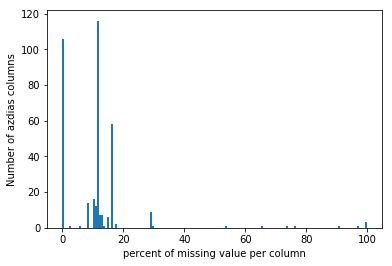

In [24]:
# plot a histogram to view the distribution of columns with missing data 

plt.hist(azdias_missing_column_percent['pct_miss'], bins=150)
plt.xlabel('percent of missing value per column')
plt.ylabel('Number of azdias columns')
plt.show()

Based both the percentage of missing data in the column data and the relevant distribution plot, we will drop columns, which the missing data exceeds 20%

In [25]:
# identify columns to drop with missing data exceeding 20%

columns_drop = azdias_missing_column_percent[azdias_missing_column_percent['pct_miss']>20]
drop_cols = columns_drop.index
drop_cols.tolist()

['ALTER_KIND4',
 'TITEL_KZ',
 'ALTER_KIND3',
 'ALTER_KIND2',
 'ALTER_KIND1',
 'AGER_TYP',
 'EXTSEL992',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'ALTERSKATEGORIE_FEIN',
 'D19_KONSUMTYP',
 'D19_VERSI_ONLINE_QUOTE_12',
 'D19_TELKO_ONLINE_QUOTE_12',
 'D19_LETZTER_KAUF_BRANCHE',
 'D19_LOTTO',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_SOZIALES']

In [26]:
# drop columns with missing data exceeding 20%

azdias.drop(drop_cols, axis=1, inplace=True)

azdias.shape

(891221, 347)

In [27]:
# identify the number of missing data in each azdias row 

azdias_missing_row_percent = pd.DataFrame(azdias.isnull().sum(axis=1).sort_values(ascending=False)/azdias.shape[1]*100,
                                          columns = ['pct_miss'])

azdias_missing_row_percent

,pct_miss
472919,71.181556
732775,70.605187
643174,70.605187
469054,70.317003
80444,70.317003
15680,70.317003
212053,70.317003
15284,70.317003
826869,70.317003
537799,70.317003


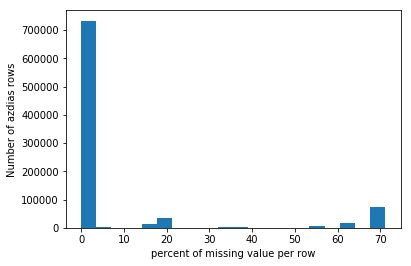

In [28]:
# plot a histogram to view the distribution of rows with missing data 

plt.hist(azdias_missing_row_percent['pct_miss'], bins=20)
plt.xlabel('percent of missing value per row')
plt.ylabel('Number of azdias rows')
plt.show()

In [29]:
# identify rows to drop with missing data exceeding 20%

rows_drop = azdias_missing_row_percent[azdias_missing_row_percent['pct_miss']>20]

drop_rows = rows_drop.index


In [30]:
# drop columns with missing data exceeding 20%

azdias.drop(drop_rows, axis=0, inplace=True)

azdias.shape

(776566, 347)

After removing the columns and rows with large counts of missing data, the azdias dataframe now stands with 784,245 rows and 347 columns. 

### Part 0.4 Create a data preparation function that can be used repeatly

In [6]:
def prep_data(df, drop_rows=True):
    
    # step 1 - modify categorical data columns and drop columns
    
    print('step 1 - categorical column modification')
    
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].replace('X', np.NaN)
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype(float)
    
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace('XX', np.NaN)
    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(float)
    
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace('X', np.NaN)
    
    
    df['WORK_DEU_2015'] = df['CAMEO_DEU_2015'].str[0]
    df['LIFE_DEU_2015'] = df['CAMEO_DEU_2015'].str[1]
    
    df['WORK_DEU_2015'] = df['WORK_DEU_2015'].replace('X', np.NaN)
    df['WORK_DEU_2015'] = df['WORK_DEU_2015'].astype(float)
    
    df['LIFE_DEU_2015'] = df['LIFE_DEU_2015'].replace('A',0).replace('B',1).replace('C',2).replace('D',3).replace('E',4).replace('F',5)
    df['LIFE_DEU_2015'] = df['LIFE_DEU_2015'].replace('X', np.NaN)
    
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace('O', 0).replace('W', 1)
    
    df = df.drop(['D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'CAMEO_DEU_2015'], axis=1)
    
    print('step 1 - completed')
    
    # step 2 - data type standardization 
    
    print('step 2 - data standardization')
    
    # standardize numerical columns to float 
    for col in df.columns: 
        if df[col].dtype == np.int64:
            df[col] = df[col].astype(np.float64)
            
    print('step 2 - completed')
            
    
    # step 3 - load the features reference dataset
    
    print('step 3 - feature reference load')
    features = pd.read_excel('DIAS Attributes - Values 2017.xlsx')
    del features['Unnamed: 0']

    # Using forward fill method to fill 'Attirbute' and 'Description' columns
    features.fillna(method = 'ffill', inplace=True)
    
    print('stpe 3 - completed')
    
    # step 4 - create missing value list
    
    print('step 4 - missing data treatment')
    
    # Extract the records that have 'unknown' meaning from the Features dataset
    features_unknown = features[features['Meaning']=='unknown']

    unknown = []

    for val in features_unknown.Value:
        # consider the integer value 
        if isinstance(val, int):
            unknown.append([val])
        # consider the string value - e.g., (-1, 0)
        elif isinstance(val, str):
            split_list = val.split(',')
            int_list = [int(x) for x in split_list]
            unknown.append(int_list)
        
    unknown_dict = {}
    for attr, value_list in zip(features_unknown.Attribute, unknown):
        unknown_dict[attr] = value_list
    
    # map unknown_dict to dateset and replace no-meaning values with NaN

    for key in unknown_dict: 
        for x in unknown_dict[key]:
            try:
                df[key] = df[key].replace(x, np.NaN)
        
            except:
                continue
    
    print('step 4 - completed')
                
    # step 5 - determine the columns and rows to drop based on the number of NaN values
    print('Step 5 - final data prep')
    
    # drop columns with 20% data missing 
    
    df = df.dropna(thresh=df.shape[0]*0.7, how='all', axis=1)
    
    print('step 5 - column drop completed')
    
    # drop rows with 20% data missing
    
    df_prep = df.dropna(thresh=df.shape[1]*0.8, how='all', axis=0)
      
    print('step 5 - row drop completed')
    
    print(df_prep.shape) 
    
    print(df.get_dtype_counts())
    
    return df_prep

### Part 0.5 - input data preparation for unsupervised and supervised learning models

In [3]:
azdias_orig = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
azdias_prep = prep_data(azdias_orig)

step 1 - categorical column modification
step 1 - completed
step 2 - data standardization
step 2 - completed
step 3 - feature reference load
stpe 3 - completed
step 4 - missing data treatment
step 4 - completed
Step 5 - final data prep
step 5 - column drop completed
step 5 - row drop completed
(776006, 356)
float64    356
dtype: int64


In [12]:
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
# drop 3 additional columns from customer dataset 

customers = customers.drop(['CUSTOMER_GROUP', 'ONLINE_PURCHASE', 'PRODUCT_GROUP'], axis=1)

In [14]:
customers_prep = prep_data(customers)

step 1 - categorical column modification
step 1 - completed
step 2 - data standardization
step 2 - completed
step 3 - feature reference load
stpe 3 - completed
step 4 - missing data treatment
step 4 - completed
Step 5 - final data prep
step 5 - column drop completed
step 5 - row drop completed
(139493, 354)
float64    354
dtype: int64


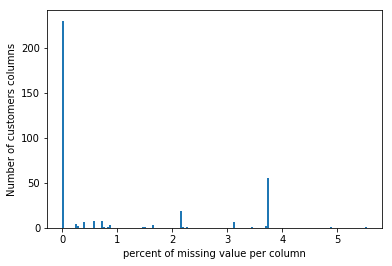

In [16]:
customers_missing_column = pd.DataFrame(customers_prep.isnull().sum().sort_values(ascending=False)/customers_prep.shape[0]*100,
                                             columns = ['pct_miss'])

plt.hist(customers_missing_column['pct_miss'], bins=150)
plt.xlabel('percent of missing value per column')
plt.ylabel('Number of customers columns')
plt.show()

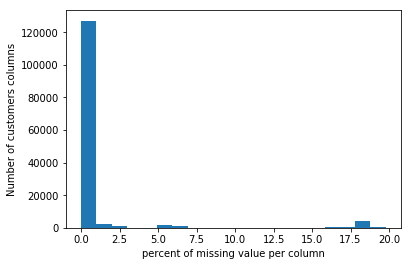

In [17]:
customers_missing_row = pd.DataFrame(customers_prep.isnull().sum(axis=1).sort_values(ascending=False)/customers_prep.shape[1]*100,
                                             columns = ['pct_miss'])

plt.hist(customers_missing_row['pct_miss'], bins=20)
plt.xlabel('percent of missing value per column')
plt.ylabel('Number of customers columns')
plt.show()

In [31]:
columns_common = [col for col in azdias_prep.columns if col in customers_prep.columns]

azdias_prep = azdias_prep[columns_common]

azdias_prep.shape

(776006, 354)

In [32]:
customers_prep.shape

(139493, 354)

In [33]:
azdias_prep.to_csv('./azdias_prep.csv')

In [18]:
customers_prep.to_csv('./customers_prep.csv')

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [2]:
from sklearn.preprocessing import Imputer, StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans

In [3]:
azdias_input = pd.read_csv('azdias_prep.csv')

In [4]:
customer_input = pd.read_csv('customers_prep.csv')

In [5]:
azdias_input.isnull().sum().sum(), customer_input.isnull().sum().sum()

(4371891, 443698)

### Part 1.1 Imputing missing values in both datasets

In [5]:
# Apply Imputer function to fill missing values  

imputing = Imputer()

azdias_input = pd.DataFrame(imputing.fit_transform(azdias_input), columns = azdias_input.columns)

azdias_input.isnull().sum().sum()

0

In [6]:
customer_input = pd.DataFrame(imputing.fit_transform(customer_input), columns = customer_input.columns)

customer_input.isnull().sum().sum()

0

### Part 1.2. Applying feature scaling for input data normalization

In [7]:
# Apply feature scaling to standardize features by removing the mean and scaling to the unit variance

scaling = StandardScaler()

azdias_input = pd.DataFrame(scaling.fit_transform(azdias_input), columns = azdias_input.columns)

azdias_input.head(15)

,Unnamed: 0,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WORK_DEU_2015,LIFE_DEU_2015
0,-1.729579,1.061545,1.263224,-1.433609,1.638433,0.172203,-0.127433,-0.305735,0.226948,0.308532,...,1.073113,1.469709,-0.682166,0.555335,-0.033219,1.147870,0.958139,-1.682984,0.986629,-1.287865
1,-1.729575,1.061564,1.263224,0.798038,0.742742,0.107898,-0.127433,-0.305735,-0.633953,-0.043667,...,0.457820,0.027470,-0.682166,0.555335,-1.071194,1.147870,0.958139,0.167847,-0.622914,0.300986
2,-1.729572,1.061568,-0.935306,0.272944,-0.152949,-0.470853,-0.127433,-0.305735,-1.494855,-0.395865,...,0.765467,1.830268,0.000000,0.555335,1.523744,-0.273550,0.958139,1.093263,-1.427686,-1.287865
3,-1.729568,1.061626,-0.935306,1.191858,0.070974,-0.342242,-0.127433,-0.305735,1.948750,-0.325425,...,-0.772765,-0.693649,-1.266653,0.555335,-0.552207,0.437160,-1.043690,0.167847,0.181857,-0.493439
4,-1.729564,1.061638,-0.935306,-0.120876,-0.824718,-0.213631,-0.127433,-0.305735,-0.633953,-0.395865,...,-0.157472,-0.693649,1.071295,0.555335,1.523744,0.437160,0.958139,-1.682984,0.986629,0.300986
5,-1.729560,1.061654,1.263224,-1.433609,0.000000,-0.277936,-0.127433,-0.305735,-0.633953,-0.325425,...,0.765467,1.469709,-0.682166,0.555335,0.485769,0.437160,0.958139,-0.757568,-0.622914,-1.287865
6,-1.729556,1.061704,-0.935306,0.404218,0.070974,-0.149325,-0.127433,-0.305735,-0.633953,-0.184546,...,1.380759,1.109149,0.486808,0.555335,-1.590182,-1.694970,-1.043690,-1.682984,-1.427686,1.095412
7,-1.729552,0.032316,1.263224,0.666765,0.518819,-0.406547,3.039025,-0.305735,-0.633953,-0.395865,...,1.073113,0.748589,0.486808,0.028211,-1.590182,1.858581,-1.043690,0.167847,-1.830072,-1.287865
8,-1.729548,0.032347,0.163959,0.798038,0.742742,0.043592,-0.127433,-0.305735,-0.633953,-0.043667,...,-2.003350,-1.775328,-0.097679,-2.607411,1.523744,0.437160,0.958139,0.167847,-1.830072,1.889837
9,-1.729544,0.032394,-0.935306,-0.120876,-0.824718,-0.149325,-0.127433,-0.305735,-0.633953,-0.114106,...,1.073113,1.469709,1.071295,0.555335,0.485769,-0.273550,0.958139,0.167847,1.389015,1.095412


In [8]:
customer_input = pd.DataFrame(scaling.fit_transform(customer_input), columns = customer_input.columns)

customer_input.head(15)

,Unnamed: 0,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WORK_DEU_2015,LIFE_DEU_2015
0,-1.731635,-1.560369,-0.373588,-0.218802,-0.076200,-0.281250,-0.128765,-0.275151,-0.199563,-0.264885,...,-0.538242,-0.519230,0.944691,0.290308,1.566242,0.454570,-0.702326,0.658680,-1.408280,-1.415298
1,-1.731598,0.865017,-0.373588,-0.856981,-2.544881,-0.281250,-0.128765,-0.275151,-0.916971,-0.264885,...,2.948370,3.550555,0.944691,0.290308,-0.830511,0.454570,1.423841,0.658680,0.277956,0.866918
2,-1.731580,0.865035,-0.373588,-0.537892,-0.569936,-0.353752,0.000000,-0.275151,-1.634380,-0.264885,...,-0.189581,-0.519230,0.000000,0.290308,1.566242,-1.080782,-0.702326,0.658680,-0.143603,0.106180
3,-1.731562,0.865053,-0.373588,1.376645,0.911272,0.153758,-0.128765,-0.275151,1.235255,0.174372,...,0.159080,0.385167,-1.239977,0.290308,-0.351160,-1.080782,-0.702326,-0.656653,1.121073,-0.654559
4,-1.731544,0.865306,-0.373588,-0.059258,-0.076200,-0.281250,-0.128765,-0.275151,-0.199563,-0.264885,...,-0.886903,-0.971429,0.944691,0.290308,-1.309861,-0.313106,-0.702326,-0.656653,0.277956,0.866918
5,-1.731526,0.865595,-0.373588,-0.218802,-0.076200,-0.281250,-0.128765,-0.275151,-0.199563,-0.264885,...,-0.189581,-0.519230,0.944691,0.290308,1.566242,-1.080782,-0.702326,0.658680,-0.565162,-0.654559
6,-1.731508,0.865703,-0.373588,-0.218802,-0.323068,-0.281250,-0.128765,-0.275151,-0.199563,-0.264885,...,-0.886903,-0.971429,0.944691,0.290308,-0.351160,0.454570,-0.702326,0.658680,-1.408280,0.866918
7,-1.731490,0.111418,0.658862,-1.016526,-1.557409,5.011348,3.864355,-0.275151,-0.916971,5.665085,...,2.251047,2.646158,0.944691,-5.220098,0.128191,0.454570,1.423841,0.658680,1.964191,1.627657
8,-1.731472,0.111652,-0.373588,1.376645,0.664404,-0.281250,-0.128765,-0.275151,0.517846,-0.264885,...,0.159080,0.385167,-1.239977,0.290308,0.607541,-1.080782,-0.702326,-0.656653,-1.408280,0.866918
9,-1.731436,0.111869,-0.373588,-0.218802,-0.076200,-0.281250,-0.128765,-0.275151,-0.916971,-0.264885,...,-0.189581,-0.519230,0.944691,-5.220098,0.128191,-1.080782,-0.702326,0.658680,-0.986721,0.866918


### Part 1.3. Performing Principal Component Analysis (PCA) for feature reduction

In [9]:
# create a PCA function 

def apply_pca(df, num_components):
    '''
    Apply PCA data transformation to a given dataframe (df) by creating components with given numbers (num_components)
    
    Input: num_components --> number of principal components to be created
           df --> input dataframe
           
    Output: pca - resulting PCA object 
            X_pca - Transformed X matrix with principal components
    '''
    pca_start = time.time()
    print("pca_start: ", pca_start)
    pca = PCA(num_components, random_state=42)
    pca_stop = time.time()
    pca_run = pca_stop - pca_start
    print(pca_run)
    
    X_pca_start = time.time()
    print("X_pca_start: ", X_pca_start)
    X_pca = pca.fit_transform(df)
    X_pca_stop = time.time()
    X_pca_run = X_pca_stop - X_pca_start
    print(X_pca_run)
    
    return pca, X_pca

In [12]:
# Apply PCA to azdias data with number of componets set to None 

pca_azdias, X_pca_azdias = apply_pca(azdias_input, None)

In [14]:
X_pca_azdias.shape

(776006, 355)

In [17]:
# identify the principle component counts that represent 90% of variance

for i in range(0, 355):
    if np.cumsum(pca_azdias.explained_variance_ratio_)[i]>0.9:
        print('90% cumulative varience is represented by first {} principal components'.format(i+1))
        break

90% cumulative varience is represented by first 177 principal components


In [30]:
# % of variance covered by the top 35 (20%) principle components

np.cumsum(pca_azdias.explained_variance_ratio_)[35]

0.54048482138036669

In [33]:
np.cumsum(pca_azdias.explained_variance_ratio_)

array([ 0.08624372,  0.13851112,  0.18770803,  0.22592223,  0.24980598,
        0.26998142,  0.2891092 ,  0.30642991,  0.32184547,  0.33610284,
        0.34933053,  0.36195973,  0.37342909,  0.38371051,  0.39364106,
        0.40324684,  0.41258967,  0.42158062,  0.4301714 ,  0.43851819,
        0.44630865,  0.45398719,  0.46149503,  0.46882382,  0.47560204,
        0.48221685,  0.48873528,  0.49521295,  0.5015603 ,  0.50763804,
        0.51333177,  0.51895219,  0.52453441,  0.53008413,  0.53536867,
        0.54048482,  0.54546382,  0.55040372,  0.55520923,  0.55993391,
        0.56451694,  0.56909112,  0.57361321,  0.57806332,  0.582372  ,
        0.58658227,  0.59068688,  0.59477439,  0.59883693,  0.6027772 ,
        0.60666098,  0.61053725,  0.61436249,  0.61811896,  0.62182818,
        0.62544945,  0.62902304,  0.63258874,  0.63606923,  0.63952867,
        0.64294638,  0.64634325,  0.64961213,  0.65285558,  0.65606143,
        0.65923515,  0.66236963,  0.66546997,  0.6685231 ,  0.67

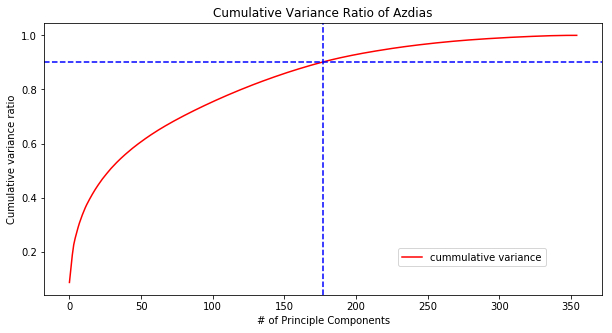

In [25]:
# Plot cumulative variance of principal component 

fig, ax1 = plt.subplots(figsize = (10, 5))

ax1.plot(np.cumsum(pca_azdias.explained_variance_ratio_), label = 'cummulative variance', color = 'red')

ax1.set_xlabel('# of Principle Components')
ax1.set_ylabel('Cumulative variance ratio')
ax1.set_title('Cumulative Variance Ratio of Azdias')
ax1.axvline(177, linestyle = 'dashed', color = 'blue')
ax1.axhline(np.cumsum(pca_azdias.explained_variance_ratio_)[177], linestyle='dashed', color = 'blue')
fig.legend(loc=(0.65, 0.2))

plt.show()

Based on the PCA results, we observe the following: 
1) out of 355 principal components, 177 of them represent 90% of the variance 
2) top 20% (35) principal components represent 54% of the variance 

Now let's set the num_components as 177 

In [10]:
pca_azdias_177, X_pca_azdias_177 = apply_pca(azdias_input, 177)

pca_start:  1662391403.540973
0.0167391300201416
X_pca_start:  1662391403.5579872
1203.966164112091


In [11]:
pca_azdias_177.components_.shape

(177, 355)

In [12]:
pca_azdias_177.components_

array([[-0.00099544,  0.02129888, -0.06703679, ...,  0.02075477,
        -0.12446451,  0.00723105],
       [ 0.0015735 , -0.03745259, -0.01056589, ..., -0.11641727,
         0.04778928, -0.03089711],
       [-0.00385172,  0.07855382,  0.01322746, ..., -0.0611317 ,
        -0.01036298,  0.00181518],
       ..., 
       [ 0.00242671,  0.03301998,  0.00280893, ..., -0.00148092,
        -0.01283444,  0.00704548],
       [-0.00385738,  0.08697362, -0.03079043, ..., -0.06578724,
         0.01896507,  0.03481152],
       [ 0.00073694, -0.06965791,  0.00022895, ...,  0.04245247,
         0.00558622, -0.00247478]])

In [13]:
pca_azdias_177.explained_variance_ratio_

array([ 0.08624372,  0.0522674 ,  0.04919691,  0.0382142 ,  0.02388375,
        0.02017544,  0.01912779,  0.0173207 ,  0.01541556,  0.01425737,
        0.01322769,  0.0126292 ,  0.01146936,  0.01028142,  0.00993055,
        0.00960577,  0.00934283,  0.00899095,  0.00859078,  0.00834679,
        0.00779045,  0.00767855,  0.00750784,  0.00732879,  0.00677822,
        0.00661481,  0.00651842,  0.00647767,  0.00634735,  0.00607773,
        0.00569373,  0.00562042,  0.00558221,  0.00554972,  0.00528454,
        0.00511614,  0.00497899,  0.00493989,  0.0048055 ,  0.00472466,
        0.00458302,  0.00457414,  0.00452207,  0.00445009,  0.00430863,
        0.00421022,  0.00410458,  0.00408746,  0.00406247,  0.0039402 ,
        0.00388374,  0.00387618,  0.00382519,  0.0037563 ,  0.00370905,
        0.00362122,  0.00357342,  0.00356556,  0.00348027,  0.00345924,
        0.00341759,  0.00339676,  0.00326862,  0.00324314,  0.00320554,
        0.00317338,  0.00313427,  0.00309974,  0.0030527 ,  0.00

### Part 1.4. Interpretating Principle Components Outcome

In [14]:
# create dataframe of 177 components

azdias_component = pd.DataFrame(pca_azdias_177.components_.round(3), columns = azdias_input.columns)

In [15]:
# update dataframe index 

PC_names = ['PC{}'.format(i) for i in range(0, len(pca_azdias_177.components_))]

azdias_component.index = PC_names

azdias_component = azdias_component.drop('Unnamed: 0', axis=1)

azdias_component.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WORK_DEU_2015,LIFE_DEU_2015
PC0,0.021,-0.067,0.046,-0.004,-0.075,-0.018,0.036,0.083,-0.074,0.003,...,-0.100,-0.086,-0.061,0.021,0.043,-0.079,-0.004,0.021,-0.124,0.007
PC1,-0.037,-0.011,0.094,0.122,0.011,-0.010,0.065,0.071,0.008,-0.007,...,-0.082,-0.034,-0.101,-0.050,0.011,0.037,0.005,-0.116,0.048,-0.031
PC2,0.079,0.013,0.028,0.053,0.022,0.022,0.023,0.013,0.019,0.008,...,-0.006,0.018,-0.031,-0.032,-0.080,0.007,0.008,-0.061,-0.010,0.002
PC3,-0.041,-0.102,0.002,-0.098,0.036,0.023,-0.010,0.057,0.038,0.011,...,-0.118,-0.132,0.020,0.037,-0.068,-0.058,-0.005,0.131,0.036,0.039
PC4,-0.127,0.025,0.002,0.033,0.007,0.012,-0.001,-0.019,0.010,0.004,...,-0.003,-0.009,-0.004,-0.016,-0.031,0.012,-0.003,-0.051,-0.035,0.041


In [17]:
azdias_component.to_csv('azdias_component.csv')

In [16]:
# create dataframe for variance ratios 

azdias_var_ratio = pd.DataFrame(pca_azdias_177.explained_variance_ratio_.round(3).reshape(-1,1),
                                index=PC_names,
                                columns=['var_ratio'])

azdias_var_ratio.sort_values(by=['var_ratio'], ascending=False)

,var_ratio
PC0,0.086
PC1,0.052
PC2,0.049
PC3,0.038
PC4,0.024
PC5,0.020
PC6,0.019
PC7,0.017
PC8,0.015
PC9,0.014


In [51]:
azdias_var_ratio.to_csv('azdias_var_ratio.csv')

In [4]:
azdias_component = pd.read_csv('azdias_component.csv')

azdias_var_ratio = pd.read_csv('azdias_var_ratio.csv')

Now we will build a funciton to combine principle components with data feature names

In [17]:
def component_map(df, pca_df):
    '''
    This fucntion maps principle components with data feature names
    input:
        df - dataframe 
        pca_df - pca object
    output:
        df_component_mapped - mapped PCs with feature names as a dataframe
    '''
    
    # build component dataframe
    df_component = pd.DataFrame(pca_df.components_.round(3), columns = df.columns)
    
    df_component = df_component.drop('Unnamed: 0', axis=1)
    
    # update dataframe index
    PC_names = ['PC{}'.format(i) for i in range(0, len(pca_df.components_))]

    df_component.index = PC_names
    
    # create dataframe for variance ratios 

    df_var_ratio = pd.DataFrame(pca_df.explained_variance_ratio_.round(3).reshape(-1,1),
                                index=PC_names,
                                columns=['var_ratio'])
    
    # combine both dataframes
    
    df_component_mapped = pd.concat([df_component, df_var_ratio], axis=1)
    
    return df_component_mapped

In [18]:
azdias_component_mapped = component_map(azdias_input, pca_azdias_177)

azdias_component_mapped.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,WORK_DEU_2015,LIFE_DEU_2015,var_ratio
PC0,0.021,-0.067,0.046,-0.004,-0.075,-0.018,0.036,0.083,-0.074,0.003,...,-0.086,-0.061,0.021,0.043,-0.079,-0.004,0.021,-0.124,0.007,0.086
PC1,-0.037,-0.011,0.094,0.122,0.011,-0.010,0.065,0.071,0.008,-0.007,...,-0.034,-0.101,-0.050,0.011,0.037,0.005,-0.116,0.048,-0.031,0.052
PC2,0.079,0.013,0.028,0.053,0.022,0.022,0.023,0.013,0.019,0.008,...,0.018,-0.031,-0.032,-0.080,0.007,0.008,-0.061,-0.010,0.002,0.049
PC3,-0.041,-0.102,0.002,-0.098,0.036,0.023,-0.010,0.057,0.038,0.011,...,-0.132,0.020,0.037,-0.068,-0.058,-0.005,0.131,0.036,0.039,0.038
PC4,-0.127,0.025,0.002,0.033,0.007,0.012,-0.001,-0.019,0.010,0.004,...,-0.009,-0.004,-0.016,-0.031,0.012,-0.003,-0.051,-0.035,0.041,0.024


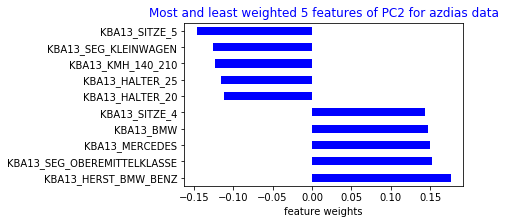

In [21]:
# plot most and least weighted features

# principal component number 
PC_no = 2

# number of most/least feature weights to display
num = 5

# display feature weights in descending order
weights = azdias_component.iloc[PC_no].sort_values(ascending=False)

# build the plot to show most/least weighted feature per 

fig1, ax1 = plt.subplots(figsize=(5,3))

weights[:num].append(weights[-num:]).plot(kind='barh', ax = ax1, color = 'blue')

plt.title("Most and least weighted {} features of PC{} for azdias data".format(num, PC_no), color = 'blue')

plt.xlabel('feature weights')

plt.show()



### Part 1.5. Conduct Unsupervised Learning analysis - K-means cluster

In [18]:
# Create a elbow plot to determine the optimal number of clusters 

def plot_elbow (X_pca, n_clusters_start, n_clusters_end, step):
    '''
    Input:
        X_pca: array of transformed data 
        n_clusters_start: starting number of clusters (integer)
        n_clusters_end: stopping number of clusters (integer)
        step - increasing step of clusters
        
    Output:
        Scoring for each cluster
        Elbow plot
    '''
    
    # determine scoring for each cluster
    scores = []
    for i in range(n_clusters_start, n_clusters_end, step):
        print(i)
        start = time.time()
        
        kmeans = KMeans(n_clusters = i, random_state = 42)
        model = kmeans.fit(X_pca)
        score = np.abs(model.score(X_pca))
        scores.append(score)
        
        end = time.time()
        run_time = end - start
        print('run time is:', run_time)
        
    # build the elbow plot
    plt.plot(range(n_clusters_start, n_clusters_end, step), scores, marker = 'x', color = 'blue');
    plt.xlabel('Number of clusters');
    plt.ylabel('Sum of squared errors');
    plt.title("Elbow plot - cluster counts vs. total squared errors");
    plt.savefig('ElbowPlot.png');
    
    return scores

1
run time is: 19.686225414276123
2
run time is: 125.56330919265747
3
run time is: 190.25231957435608
4
run time is: 279.5234019756317
5
run time is: 560.5499720573425
6
run time is: 362.43428921699524
7
run time is: 482.1048774719238
8
run time is: 607.7937815189362
9
run time is: 643.8269782066345
10
run time is: 609.0344746112823


[247679143.87906912,
 230629128.06025451,
 222569052.52406564,
 217924087.96064228,
 214148823.51132205,
 211183507.71101665,
 208550835.77539384,
 206473647.29821602,
 204518027.39718387,
 203090038.8173199]

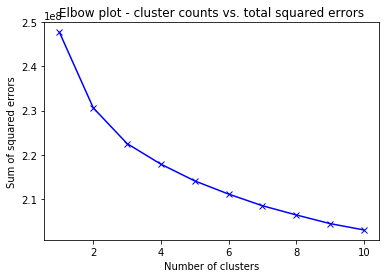

In [19]:
plot_elbow(X_pca_azdias_177, 1, 11, 1)

Based on the scoring output, we observed that after the cluster count of 8, the total error measure began to reduce less gradually. Thus, we will set the number of K-mean clusters at 8. 

In [22]:
azdias_kmeans = KMeans(n_clusters = 8, random_state = 42)

azdias_model = azdias_kmeans.fit(X_pca_azdias_177)

azdias_clusters = azdias_model.predict(X_pca_azdias_177)

In [23]:
# display the model parameters

azdias_model.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 8,
 'n_init': 10,
 'n_jobs': 1,
 'precompute_distances': 'auto',
 'random_state': 42,
 'tol': 0.0001,
 'verbose': 0}

In [25]:
# apply PCA transformation on customer data 

pca_customers_177 = pca_azdias_177.transform(customer_input)

In [26]:
# perform k-means clustering on customers 

customers_cluster = azdias_model.predict(pca_customers_177)

In [35]:
# calculate label percentage in azdias clusters

azdias_percluster = []
azdias_label = []

for label in np.unique(azdias_clusters):
    label_percent = np.round((azdias_clusters[azdias_clusters == label].size/azdias_clusters.size*100), 1)
    azdias_percluster.append(label_percent)
    azdias_label.append(label)
    

In [36]:
azdias_label, azdias_percluster

([0, 1, 2, 3, 4, 5, 6, 7],
 [12.300000000000001,
  16.199999999999999,
  8.4000000000000004,
  15.0,
  9.3000000000000007,
  13.5,
  9.4000000000000004,
  15.800000000000001])

In [39]:
# calculate label percentage in customer clusters

customer_percluster = []
customer_label = []

for label in np.unique(customers_cluster):
    label_percent = np.round((customers_cluster[customers_cluster == label].size/customers_cluster.size*100), 1)
    customer_percluster.append(label_percent)
    customer_label.append(label)

In [40]:
customer_label, customer_percluster

([0, 1, 2, 3, 4, 5, 6, 7],
 [8.3000000000000007,
  16.300000000000001,
  8.0,
  10.6,
  14.4,
  16.5,
  4.7999999999999998,
  21.100000000000001])

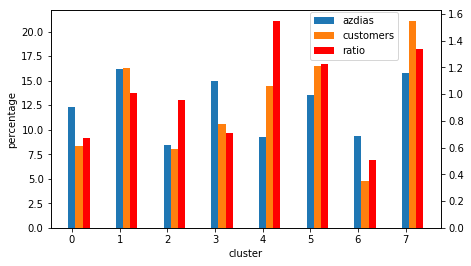

In [47]:
# plot percentage for individual cluster 

fig, ax = plt.subplots(figsize = (7, 4))

width = 0.15

x = np.array(azdias_label)

ax.bar(x, azdias_percluster, width, label = 'azdias')
ax.bar(x + width, customer_percluster, width, label = 'customers')
ax.set_ylabel('percentage')
ax.set_xlabel('cluster')

ax1 = ax.twinx()
ax1.bar(x + 2*width,
        np.array(customer_percluster)/np.array(azdias_percluster),
        width,
        color = 'red',
        label = 'ratio')

fig.legend(bbox_to_anchor=(0.8, 0.9))

plt.show()

Based on the percentage plot between azdias and customer, we observed that the clusters 4, 5 and 7 are the top clusters represent customer clusters in the general German population - which cluster 4 shows the highest ratio. We also observed that cluster 6 presents the customer cluster in the German population the least. 

In [48]:
# Build a dataframe to show the Principal Component (PC#) vs. cluster number 

df_weight = pd.DataFrame(azdias_model.cluster_centers_.T,
                         columns = ["cluster_{}".format(i) for i in range(0,8)],
                         index = ["PC{}".format(i) for i in range(0, 177)])

df_weight.head()

,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7
PC0,-7.847733,7.668863,-0.501531,-0.331490,1.724691,-4.137319,-3.885565,3.653021
PC1,1.709709,3.358365,6.156501,-0.000587,-4.150417,-2.891439,1.762673,-4.173921
PC2,2.396305,0.133216,2.523928,0.475175,5.657730,-0.920312,-6.091592,-2.695685
PC3,-0.309157,1.077359,1.797358,-5.145657,1.575780,1.973316,1.717233,-0.574864
PC4,-0.720308,-0.377780,-0.623125,0.359432,1.428689,-1.594463,3.388937,-0.565926


In [59]:
# plot most and least 5 weighted components of each cluster 

def plot_weighted_clusters(cluster_number):
    
    fig, ax = plt.subplots(figsize = (7, 4))
    
    num = df_weight.iloc[:, cluster_number].sort_values(ascending = False)
    
    num[-5:].append(num[:5]).plot(kind = 'barh', color = 'gray')
    
    plt.xlabel("weighted component")
    
    plt.show()

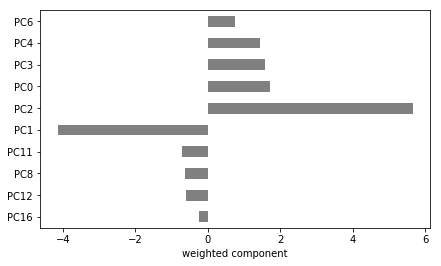

In [60]:
plot_weighted_clusters(4)

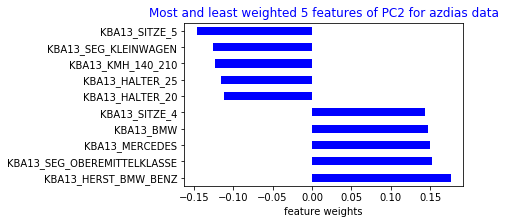

In [38]:
# plot most and least weighted features

# principal component number 
PC_no = 2

# number of most/least feature weights to display
num = 5

# display feature weights in descending order
weights = azdias_component.iloc[PC_no].sort_values(ascending=False)

# build the plot to show most/least weighted feature per 

fig1, ax1 = plt.subplots(figsize=(5,3))

weights[:num].append(weights[-num:]).plot(kind='barh', ax = ax1, color = 'blue')

plt.title("Most and least weighted {} features of PC{} for azdias data".format(num, PC_no), color = 'blue')

plt.xlabel('feature weights')

plt.show()

The top 5 weighted features for Principle Component 2 - showing the most positive weight out of Cluster 4 are: 
- KBA13_HERST_BMW_BENTS: share of BMW & Mercdes Benz
- KBA13_SEG_OBERMITTEKLASSE: share of upper middle class cars
- KBA13_MERCEDES: share of Mercedes
- KBA13_BMW: share of BMW
- KBA13_SITZE_4: number of cars with less thn 5 seats

The bottom 5 weighted features for PC2 are: 
- KBA13_SITZE_5: number of cars with 5 seats 
- KBA13_SEG_KLEINWAGEN: share of small and very small cars
- KBA13_KMH_140_210: share of cars with max speed between 140 and 210 km/h
- KBA13_HALTER_25: share of car owners between 21 and 25
- KAB_HALTER_20: share of car owners below 21 

This suggests that based on the customer profile, the most likley customer within general population are upper middle class customers owning luxury sedans (BMW, Mercedes, etc.), and the most unlikely customers are young customers who alos owning small vehicles. 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [11]:
from sklearn.preprocessing import Imputer, StandardScaler 
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder

In [3]:
mailout_train = pd.read_csv('./Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
mailout_train.shape

(42962, 367)

In [7]:
train_clean = prep_data(mailout_train)

step 1 - categorical column modification
step 1 - completed
step 2 - data standardization
step 2 - completed
step 3 - feature reference load
stpe 3 - completed
step 4 - missing data treatment
step 4 - completed
Step 5 - final data prep
step 5 - column drop completed
step 5 - row drop completed
(34880, 357)
float64    357
dtype: int64


In [8]:
train_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,WORK_DEU_2015,LIFE_DEU_2015
0,1763.0,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,0.0,...,1.0,6.0,9.0,3.0,3.0,0.0,2.0,4.0,5.0,3.0
1,1771.0,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,4.0,9.0,7.0,1.0,0.0,2.0,3.0,5.0,1.0
2,1776.0,1.0,9.0,7.0,0.0,NaN,0.0,0.0,1.0,0.0,...,2.0,NaN,9.0,2.0,3.0,0.0,1.0,4.0,2.0,3.0
3,1460.0,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,0.0,...,11.0,6.0,9.0,1.0,3.0,0.0,2.0,4.0,2.0,3.0
4,1783.0,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,0.0,...,1.0,6.0,9.0,3.0,3.0,0.0,1.0,3.0,7.0,1.0


In [9]:
# capture % of customers responded from the training dataset 
train_clean['RESPONSE'].mean()*100

1.2356651376146788

In [13]:
# imputing and scaling the input data

imputing = Imputer()

train_clean = pd.DataFrame(imputing.fit_transform(train_clean), columns = train_clean.columns)

scaling = StandardScaler()

train_clean = pd.DataFrame(scaling.fit_transform(train_clean), columns = train_clean.columns)

In [14]:
train_clean.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB,WORK_DEU_2015,LIFE_DEU_2015
0,-1.652470,-0.297242,-0.379551,-0.430286,0.554638,-1.331700e-01,-0.225003,-0.751780,0.477151,-0.091887,...,-0.836804,8.187246e-01,0.25854,-0.520710,0.204325,-0.111854,0.852988,0.586278,0.015625,0.888184
1,-1.652149,1.445440,0.443089,0.731416,-0.378337,-1.331700e-01,-0.225003,-0.017062,-0.370505,-0.091887,...,-0.836804,-3.539439e-01,0.25854,1.437075,-1.432717,-0.111854,0.852988,-0.645464,0.015625,-0.632276
2,-1.651948,-0.297242,-0.215023,-0.662626,-0.444978,-1.888766e-17,-0.225003,-1.486499,-0.370505,-0.091887,...,-0.439558,5.207694e-16,0.25854,-1.010157,0.204325,-0.111854,-1.172350,0.586278,-1.225756,0.888184
3,-1.664638,-0.297242,-0.708608,-0.894966,-0.178414,-1.331700e-01,-0.225003,-0.017062,-0.158591,-0.091887,...,3.135654,8.187246e-01,0.25854,-1.499603,0.204325,-0.111854,0.852988,0.586278,-1.225756,0.888184
4,-1.651667,-0.297242,-0.215023,-0.197945,3.086999,-1.331700e-01,-0.225003,-0.751780,2.666929,-0.091887,...,-0.836804,8.187246e-01,0.25854,-0.520710,0.204325,-0.111854,-1.172350,-0.645464,0.843212,-0.632276


In [15]:
# Creat train and test split datasets

train_clean_X = train_clean.drop(columns = 'RESPONSE')

label_encoder = LabelEncoder()

train_clean_Y = label_encoder.fit_transform(train_clean['RESPONSE'])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(train_clean_X, 
                                                    train_clean_Y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [17]:
# dispaly train/test split results
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 27904 samples.
Testing set has 6976 samples.


In [18]:
# Building a supervised classification model 

classifiers = {"RandomForestCalssifier":RandomForestClassifier(random_state=42),
               "AdaBoostClassifer":AdaBoostClassifier(random_state=42),
               "GradientBoostClassifier":GradientBoostingClassifier(random_state=42)}

classifier_params = [{} for i in range(len(classifiers))]

In [19]:
def grid_search(X, y, classifiers, classifier_params, scoring = 'roc_auc'):
    '''
    input:
        X - features of dataset
        y - labels of dataset
        classifiers - a list of classification algorithms to fit 
        classifier_params - parameters of the classifier
        scoring - performance metric result 
        
    output: 
        scores - classifier performance indications
        best_estimators: list of best estimation parameters
    '''
    
    classifier_list = list(classifiers.values())
    scores = []
    best_estimators = []
    
    for i in range(len(classifier_list)):
        clf = GridSearchCV(classifier_list[i],
                           param_grid = classifier_params[i],
                           cv = StratifiedKFold(n_splits=5),
                           scoring = scoring, 
                           n_jobs = -1, 
                           verbose = 3, 
                           return_train_score = True)
        
        clf.fit(X, y)
        scores.append(clf.best_score_)
        best_estimators.append(clf.best_estimator_)
        print("Best scoring of {}: {}".format(classifier_list[i], clf.best_score_))
        print("Best estimator of {}: {}".format(classifier_list[i], clf.best_estimator_))
        
    return scores, best_estimators
    
    

In [21]:
scores, best_estimators = grid_search(X_train,
                                      y_train, 
                                      classifiers = classifiers, 
                                      classifier_params = classifier_params, 
                                      scoring = 'roc_auc')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ........................ , score=0.530274500907441, total=   1.0s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ....................... , score=0.5280021173623715, total=   1.0s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    2.1s remaining:    0.0s


[CV] ....................... , score=0.5794500164903014, total=   1.2s
[CV]  ................................................................
[CV] ....................... , score=0.5229227972664449, total=   0.9s
[CV]  ................................................................
[CV] ....................... , score=0.5247034941542521, total=   1.0s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.5s finished


Best scoring of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False): 0.5370694481552991
Best estimator of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False): RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_le

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


[CV] ....................... , score=0.7833938294010889, total=  11.0s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   22.4s remaining:    0.0s


[CV] ....................... , score=0.7354316496181664, total=  10.7s
[CV]  ................................................................
[CV] ....................... , score=0.7448784191809049, total=  10.9s
[CV]  ................................................................
[CV] ....................... , score=0.7703348426007123, total=  10.7s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.7s finished


Best scoring of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42): 0.7543298063777789
Best estimator of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42): AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.7757914902198023, total=  31.6s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   31.8s remaining:    0.0s


[CV] ....................... , score=0.8285516233111515, total=  31.2s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s


[CV] ....................... , score=0.7555114677902228, total=  31.2s
[CV]  ................................................................
[CV] ....................... , score=0.7921736262556278, total=  32.1s
[CV]  ................................................................
[CV] ....................... , score=0.7852067934928505, total=  31.7s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


Best scoring of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False): 0.7874491109588494
Best estimator of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False): Gradien

In [22]:
scoring = pd.DataFrame({"classifier": list(classifiers.keys()),
                        "scores_train": scores})

scoring

,classifier,scores_train
0,RandomForestCalssifier,0.537069
1,AdaBoostClassifer,0.754330
2,GradientBoostClassifier,0.787449


In [23]:
scores_t, best_estimators = grid_search(X_test,
                                      y_test, 
                                      classifiers = classifiers, 
                                      classifier_params = classifier_params, 
                                      scoring = 'roc_auc')

scoring_t = pd.DataFrame({"classifier": list(classifiers.keys()),
                        "scores_test": scores_t})

scoring_t

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.4718561428916244, total=   0.2s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    0.4s remaining:    0.0s


[CV] ....................... , score=0.5570359642770938, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.4681400966183575, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.5014492753623189, total=   0.2s
[CV]  ................................................................
[CV] ....................... , score=0.5390010351966873, total=   0.2s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.0s finished


Best scoring of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False): 0.507493979154925
Best estimator of RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False): RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_lea

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ....................... , score=0.7353125754284335, total=   2.6s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.4s remaining:    0.0s


[CV] ...................... , score=0.49318840579710144, total=   2.6s
[CV]  ................................................................
[CV] ....................... , score=0.5919323671497584, total=   2.6s
[CV]  ................................................................
[CV] ....................... , score=0.6126811594202899, total=   2.6s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.6s finished


Best scoring of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42): 0.5906419493587157
Best estimator of AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42): AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42)
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.5974897417330437, total=   8.4s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    8.4s remaining:    0.0s


[CV] ....................... , score=0.7657735940139995, total=   8.3s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   16.7s remaining:    0.0s


[CV] ....................... , score=0.7252657004830918, total=   8.4s
[CV]  ................................................................
[CV] ....................... , score=0.6510144927536232, total=   8.0s
[CV]  ................................................................
[CV] ....................... , score=0.7228778467908902, total=   8.2s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   41.4s finished


Best scoring of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False): 0.6924768068656237
Best estimator of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False): Gradien

,classifier,scores_test
0,RandomForestCalssifier,0.507494
1,AdaBoostClassifer,0.590642
2,GradientBoostClassifier,0.692477


Based on the both training and testing performance comparison among three classifiers, Gradient Boosting Classifier performed the best. 

Next, we will hyper tune the parameters for GB classifier to see if we can further imporve the performance.

In [24]:
# hypertuning Gradient Boosting Classifier parameter 

gb_class = GridSearchCV(GradientBoostingClassifier(random_state = 42),
                        param_grid = {},
                        cv = StratifiedKFold(n_splits = 5),
                        scoring = 'roc_auc',
                        n_jobs = -1,
                        verbose = 3, 
                        return_train_score = True)

gb_class.fit(X_train, y_train)

params = gb_class.best_estimator_.get_params()

print("Best score of Gradient Boosting Classifier: {}".format(gb_class.best_score_))

print("Parameters of Gradient Boosting Classifier: {}".format(params))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV]  ................................................................
[CV] ....................... , score=0.7757914902198023, total=  31.6s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   31.7s remaining:    0.0s


[CV] ....................... , score=0.8285516233111515, total=  31.1s
[CV]  ................................................................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  1.0min remaining:    0.0s


[CV] ....................... , score=0.7555114677902228, total=  31.3s
[CV]  ................................................................
[CV] ....................... , score=0.7921736262556278, total=  32.0s
[CV]  ................................................................
[CV] ....................... , score=0.7852067934928505, total=  31.8s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


Best score of Gradient Boosting Classifier: 0.7874491109588494
Parameters of Gradient Boosting Classifier: {'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'presort': 'auto', 'random_state': 42, 'subsample': 1.0, 'verbose': 0, 'warm_start': False}


In [25]:
gb_class = {"GradientBoostClassifier":GradientBoostingClassifier(random_state = 42)}

# specify range for top parameters 

gb_class_param_grid = [{'learning_rate': [0.05, 0.1, 0.15], 
                        'n_estimators': [50, 100, 150],    
                        'max_depth': [2, 3, 4]                               
                       }]

gb_scores, gb_best_estimators = grid_search(X_train,
                                            y_train,
                                            classifiers = gb_class,
                                            classifier_params = gb_class_param_grid,
                                            scoring = 'roc_auc')

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] learning_rate=0.05, max_depth=2, n_estimators=50 ................
[CV]  learning_rate=0.05, max_depth=2, n_estimators=50, score=0.7869441923774955, total=   9.6s
[CV] learning_rate=0.05, max_depth=2, n_estimators=50 ................


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    9.7s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=2, n_estimators=50, score=0.8019131881427708, total=   9.2s
[CV] learning_rate=0.05, max_depth=2, n_estimators=50 ................


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   19.0s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=2, n_estimators=50, score=0.7644724765364743, total=   9.7s
[CV] learning_rate=0.05, max_depth=2, n_estimators=50 ................
[CV]  learning_rate=0.05, max_depth=2, n_estimators=50, score=0.7927194680152068, total=   9.7s
[CV] learning_rate=0.05, max_depth=2, n_estimators=50 ................
[CV]  learning_rate=0.05, max_depth=2, n_estimators=50, score=0.7742081459532288, total=   9.7s
[CV] learning_rate=0.05, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.05, max_depth=2, n_estimators=100, score=0.7793216878402904, total=  17.3s
[CV] learning_rate=0.05, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.05, max_depth=2, n_estimators=100, score=0.8164347650736037, total=  17.3s
[CV] learning_rate=0.05, max_depth=2, n_estimators=100 ...............
[CV]  learning_rate=0.05, max_depth=2, n_estimators=100, score=0.7677385788683818, total=  16.9s
[CV] learning_rate=0.05, max_depth=2, n_estimators=100 ...........

[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, score=0.8132461181689856, total=  15.9s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, score=0.7666456170312855, total=  15.8s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, score=0.7935695494440596, total=  16.1s
[CV] learning_rate=0.1, max_depth=2, n_estimators=100 ................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=100, score=0.78590219845119, total=  15.8s
[CV] learning_rate=0.1, max_depth=2, n_estimators=150 ................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=150, score=0.7649526114135914, total=  23.3s
[CV] learning_rate=0.1, max_depth=2, n_estimators=150 ................
[CV]  learning_rate=0.1, max_depth=2, n_estimators=150, score=0.8146803791086913, total=  23.2s
[CV] learning_rate=0.1, max_depth=2, n_estimators=150 ................


[CV]  learning_rate=0.15, max_depth=2, n_estimators=150, score=0.7979254890098809, total=  22.5s
[CV] learning_rate=0.15, max_depth=2, n_estimators=150 ...............
[CV]  learning_rate=0.15, max_depth=2, n_estimators=150, score=0.7639074600078233, total=  22.8s
[CV] learning_rate=0.15, max_depth=2, n_estimators=150 ...............
[CV]  learning_rate=0.15, max_depth=2, n_estimators=150, score=0.7820288950986733, total=  22.7s
[CV] learning_rate=0.15, max_depth=2, n_estimators=150 ...............
[CV]  learning_rate=0.15, max_depth=2, n_estimators=150, score=0.7818448173155835, total=  22.4s
[CV] learning_rate=0.15, max_depth=3, n_estimators=50 ................
[CV]  learning_rate=0.15, max_depth=3, n_estimators=50, score=0.7682093163944342, total=  16.3s
[CV] learning_rate=0.15, max_depth=3, n_estimators=50 ................
[CV]  learning_rate=0.15, max_depth=3, n_estimators=50, score=0.8166490219802379, total=  16.0s
[CV] learning_rate=0.15, max_depth=3, n_estimators=50 ...........

[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 74.7min finished


Best scoring of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False): 0.7924793395457917
Best estimator of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False): Gradien

After testing out multiple sets of parameters, the GB classifier performance can be furhter improved (from 0.787 to 0.792) by increasing the number of estimators from 100 to 150. 